# Sketch Classifier for "How Do Humans Sketch Objects?"

A sketch classifier using the dataset from the paper <a href='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/'>How Do Humans Sketch Objects?</a> where the authors collected 20,000 unique sketches evenly distributed over 250 object categories - we will use a CNN (using Keras) to classify a sketch. 

<img src='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/teaser_siggraph.jpg'/>

In [51]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.misc import imresize
import os

In [52]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

In [68]:
SKETCH_DIR = '/Volumes/Storage/sketches (subset)/png/'
DEST_SKETCH_DIR = '/Volumes/Storage/sketches (subset)/sketches_training_data/'
TARGET_SIZE = (128,128)

## Create subset data 
To reduce the size of the data (and demands of training), we will use a subset of the data. 

In [54]:
def get_image_file_paths_and_categories():
    """
    Walk the root directory and for each subdirectory, obtain the 
    list of .png image files creating (and returning) a list for each category label and 
    associated filepath 
    """
    image_file_paths = [] 
    categories = [] 
    for d in os.listdir(SKETCH_DIR):
        label = d 

        if not os.path.isdir(os.path.join(SKETCH_DIR, d)):
            continue 
            
        for f in os.listdir(os.path.join(SKETCH_DIR, d)):
            full_path = os.path.join(os.path.join(SKETCH_DIR, d), f)            
            if os.path.isfile(full_path) and ".png" in full_path.lower():
                categories.append(label)
                image_file_paths.append(full_path)
    return image_file_paths, categories

In [55]:
image_file_paths, categories = get_image_file_paths_and_categories()

In [56]:
set(categories)

{'airplane',
 'alarm clock',
 'angel',
 'ant',
 'apple',
 'arm',
 'armchair',
 'ashtray',
 'axe',
 'backpack',
 'banana',
 'barn',
 'baseball bat',
 'basket',
 'bathtub',
 'bear (animal)',
 'bed',
 'bee',
 'beer-mug',
 'bell',
 'bench',
 'bicycle',
 'binoculars',
 'blimp',
 'book',
 'bookshelf',
 'boomerang',
 'bottle opener',
 'bowl',
 'brain',
 'bread',
 'bridge',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cabinet',
 'cactus',
 'cake',
 'calculator',
 'camel',
 'camera',
 'candle',
 'cannon',
 'canoe',
 'car (sedan)',
 'carrot',
 'castle',
 'cat',
 'cell phone',
 'chair',
 'chandelier',
 'church',
 'cigarette',
 'cloud',
 'comb',
 'computer monitor',
 'computer-mouse',
 'couch',
 'cow',
 'crab',
 'crane (machine)',
 'crocodile',
 'crown',
 'cup',
 'diamond',
 'dog',
 'dolphin',
 'donut',
 'door',
 'door handle',
 'dragon',
 'duck',
 'ear',
 'elephant',
 'envelope',
 'eye',
 'eyeglasses',
 'face',
 'fan',
 'feather',
 'fire hydrant',
 'fish',
 'flashlight',
 'floor lamp',
 'flower

In [62]:
TARGET_COUNT = 150 

selected_categories = [] 
available_categories = list(set(categories))

while len(selected_categories) < TARGET_COUNT:
    idx = random.randint(0, len(available_categories)-1)
    category = available_categories[idx]
    selected_categories.append(category)
    del available_categories[idx]

In [63]:
selected_categories

['human-skeleton',
 'cabinet',
 'floor lamp',
 'trombone',
 'hot-dog',
 'basket',
 'brain',
 'paper clip',
 'tooth',
 'motorbike',
 'elephant',
 'mug',
 'mosquito',
 'shovel',
 'leaf',
 'cake',
 'nose',
 'hamburger',
 'chandelier',
 'skyscraper',
 'ship',
 't-shirt',
 'flying saucer',
 'bicycle',
 'rainbow',
 'suitcase',
 'loudspeaker',
 'kangaroo',
 'present',
 'ant',
 'shoe',
 'armchair',
 'toilet',
 'bread',
 'tennis-racket',
 'fan',
 'shark',
 'owl',
 'cannon',
 'syringe',
 'comb',
 'potted plant',
 'van',
 'face',
 'frog',
 'cigarette',
 'rifle',
 'pigeon',
 'dragon',
 'ice-cream-cone',
 'angel',
 'snowboard',
 'knife',
 'spoon',
 'toothbrush',
 'butterfly',
 'megaphone',
 'wheelbarrow',
 'dolphin',
 'trumpet',
 'church',
 'wineglass',
 'keyboard',
 'cell phone',
 'pipe (for smoking)',
 'key',
 'windmill',
 'boomerang',
 'envelope',
 'train',
 'mushroom',
 'grenade',
 'mailbox',
 'bathtub',
 'arm',
 'cactus',
 'fork',
 'bed',
 'panda',
 'teapot',
 'pickup truck',
 'piano',
 'light

In [64]:
print("Filtered categories count {}".format(len(selected_categories)))

Filtered categories count 150


In [69]:
def split_training_validation_data(shuffle=True, split=0.8, target_size=TARGET_SIZE, selected_categories=None):
    """
    Split the data into training and validation (as well as resizing the images) 
    Copies are made from the main file path and stored in a destination folder. 
    """
    
    image_scale = None
    training_samples_count = 0 
    validation_samples_count = 0 
    
    for d in os.listdir(SKETCH_DIR):
        label = d 

        if not os.path.isdir(os.path.join(SKETCH_DIR, d)) or d not in selected_categories:
            continue 
            
        file_names = []
        file_data = []
            
        for f in os.listdir(os.path.join(SKETCH_DIR, d)):
            full_path = os.path.join(os.path.join(SKETCH_DIR, d), f)            
            if os.path.isfile(full_path) and ".png" in full_path.lower():
                file_names.append(f)
                if image_scale is None:
                    image_scale = float(target_size[0]) / float(plt.imread(full_path).shape[0]) 
                file_data.append(imresize(plt.imread(full_path), image_scale))
                
        # shuffle 
        indexes = np.arange(len(file_names))
        if shuffle:
            np.random.shuffle(indexes)
        
        training_end_index = int(len(indexes) * split)
        training_indexes = indexes[:training_end_index]
        validation_indexes = indexes[training_end_index:]
            
        training_dir = os.path.join(DEST_SKETCH_DIR, 'training')
        validation_dir = os.path.join(DEST_SKETCH_DIR, 'validation')
            
        class_training_dir = os.path.join(training_dir, label)
        class_validation_dir = os.path.join(validation_dir, label)
            
        if not os.path.exists(training_dir):
            os.mkdir(training_dir)
                
        if not os.path.exists(validation_dir):
            os.mkdir(validation_dir)
                
        if not os.path.exists(class_training_dir):
            os.mkdir(class_training_dir)
                
        if not os.path.exists(class_validation_dir):
            os.mkdir(class_validation_dir)
                
        for idx in training_indexes:
            training_samples_count += 1            
            plt.imsave(
                os.path.join(class_training_dir, file_names[idx]), file_data[idx], 
                format='png', cmap='gray')
            
        for idx in validation_indexes:
            validation_samples_count += 1
            plt.imsave(
                os.path.join(class_validation_dir, file_names[idx]), file_data[idx], 
                format='png', cmap='gray')
            
    print("Finished - training samples = {}, validation samples {}".format(training_samples_count, 
                                                                           validation_samples_count))
    
    return training_samples_count, validation_samples_count

In [70]:
training_samples_count, validation_samples_count = split_training_validation_data(
    selected_categories=selected_categories)

Finished - training samples = 9600, validation samples 2400


In [71]:
print("training_samples_count {}, validation_samples_count {}".format(
    training_samples_count, validation_samples_count))

training_samples_count 9600, validation_samples_count 2400


## Data exploration 

In [77]:
def get_training_validation_data():
    training_labels = [] 
    training_filenames = [] 
    validation_labels = []
    validation_filenames = [] 
    
    training_dir = os.path.join(DEST_SKETCH_DIR, 'training')
    validation_dir = os.path.join(DEST_SKETCH_DIR, 'validation')
    
    # iterate through the training directory 
    for d in os.listdir(training_dir):
        label = d 
        
        if not os.path.isdir(os.path.join(training_dir, d)):
            continue 
            
        for f in os.listdir(os.path.join(training_dir, d)):
            full_path = os.path.join(os.path.join(training_dir, d), f)            
            if os.path.isfile(full_path) and ".png" in full_path.lower():
                training_labels.append(label)
                training_filenames.append(full_path)
    
    # iterate through the validation directory 
    for d in os.listdir(validation_dir):
        label = d 
        
        if not os.path.isdir(os.path.join(validation_dir, d)):
            continue 
            
        for f in os.listdir(os.path.join(validation_dir, d)):
            full_path = os.path.join(os.path.join(validation_dir, d), f)            
            if os.path.isfile(full_path) and ".png" in full_path.lower():
                validation_labels.append(label)
                validation_filenames.append(full_path)
                
    return training_labels, training_filenames, validation_labels, validation_filenames


In [78]:
training_labels, training_filenames, _, _ = get_training_validation_data()

In [79]:
plt.imread(training_filenames[100]).shape

(128, 128, 4)

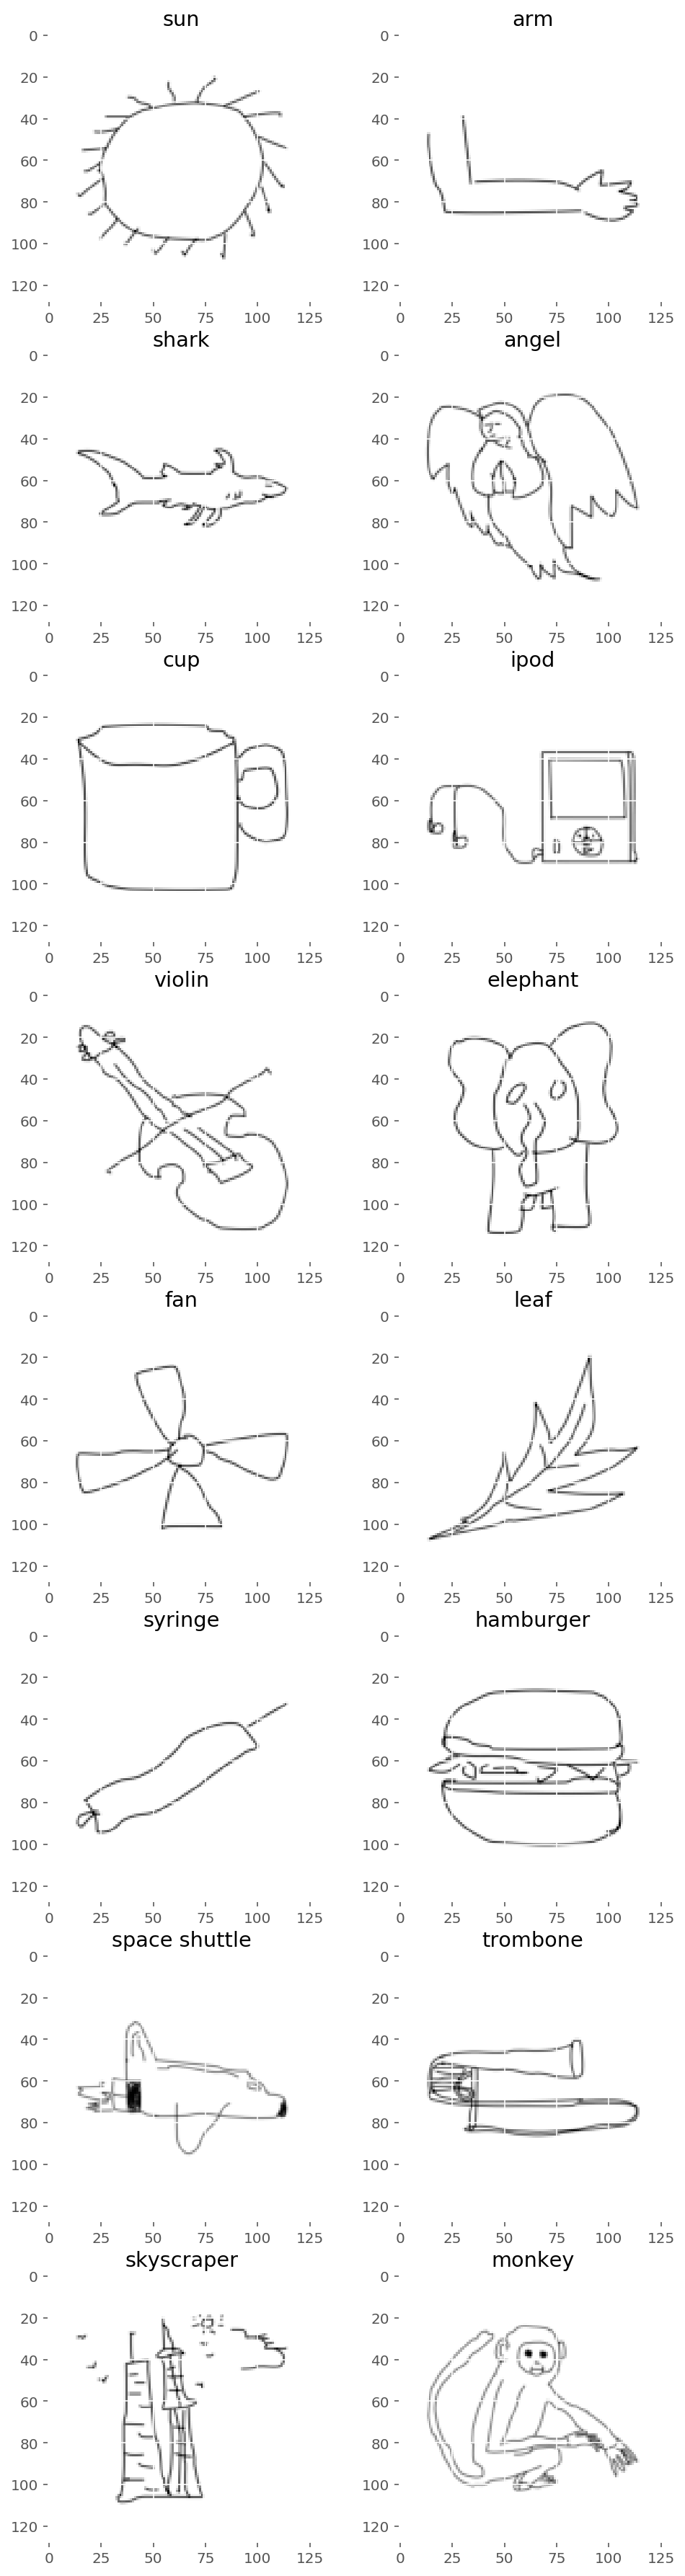

In [81]:
f, axarr = plt.subplots(8, 2, figsize=(8,32))

image_scale = 1.0 

for r in range(0, 8):
    for c in range(0, 2):
        index = random.randint(0, len(training_labels)-1)
        axarr[r, c].imshow(imresize(plt.imread(training_filenames[index]), image_scale), cmap='gray', interpolation='nearest')
        axarr[r, c].set_title(training_labels[index])